In [1]:
import os
os.chdir('../../')

INFO - main.py - 2025-03-29 20:06:42,019 - Using device: cuda
INFO - main.py - 2025-03-29 20:06:42,019 - Using device: cuda
INFO - main.py - 2025-03-29 20:06:42,019 - Using device: cuda
INFO - main.py - 2025-03-29 20:06:42,019 - Using device: cuda
INFO - main.py - 2025-03-29 20:06:42,019 - Using device: cuda
INFO - main.py - 2025-03-29 20:06:42,019 - Using device: cuda
INFO - main.py - 2025-03-29 20:06:42,019 - Using device: cuda
INFO - main.py - 2025-03-29 20:06:42,019 - Using device: cuda
INFO - main.py - 2025-03-29 20:06:42,019 - Using device: cuda


[prepare_model] Model is ready.


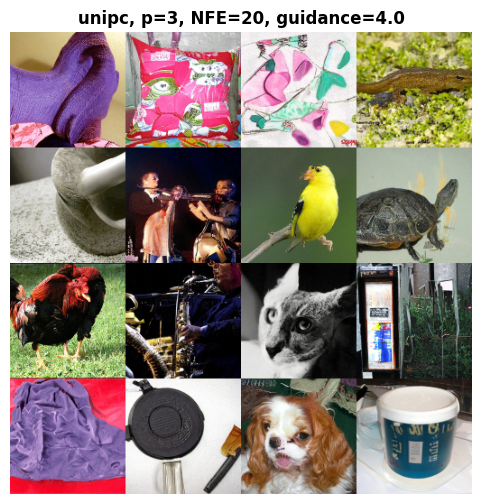

mkdir: cannot create directory ‘sample/samples’: File exists


: 

In [ ]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet128_guided.yml",  # 사용하려는 config
    "--sample",
    "--eta", "0",
    "--sample_type", "unipc",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "3",
    "--timesteps", "20",
    "--skip_type", "logSNR",
    "--scale", "4.0",
    #"--fixed_class", "207",
    "--thresholding",
    "--ni"
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device
num_samples = 16

# (a) 초기 노이즈 (배치 크기 16)
x = np.random.randn(num_samples, config.data.channels, config.data.image_size, config.data.image_size).astype(np.float32)
x = torch.tensor(x, device=device)

# (b) 모델로 샘플링 (배치 입력)
sampled_x, classes = diffusion.sample_image(x, diffusion.model, classifier=diffusion.classifier)

# (c) [-1,1] → [0,1] 범위 변환
sampled_x = inverse_data_transform(config, sampled_x)

# (d) 5x5 그리드, padding=0 => 여백 없이
grid = vutils.make_grid(sampled_x, nrow=4, padding=0)

# (e) matplotlib 시각화
grid_np = grid.permute(1, 2, 0).cpu().numpy()
grid_np = np.clip(grid_np, 0, 1)

plt.figure(figsize=(6,6))
plt.imshow(grid_np)
plt.axis('off')
title = f"{args.sample_type}, p={args.dpm_solver_order}, NFE={args.timesteps}, guidance={args.scale}"
plt.title(title, fontweight="bold")
plt.show()

!mkdir sample/samples
torch.save(sampled_x, 'sample/samples/rbfcpdtargetlgtrapz.pt')